# 3. classification #
## 3.1 MNIST ##

In [2]:
from mnist_read import load_mnist
import numpy as np

In [3]:
mnist = load_mnist(shuffle = True, one_hot = False)

Reading from saved pickle..
 - train-images shape :  (60000, 28, 28, 1)
 - test-images shape :  (10000, 28, 28, 1)
Load option.
 - normalize :  True
 - flatten :  False
 - one-hot coding :  False
 - shuffled :  True
Dataset columns.
 -  train_img
 -  train_label
 -  test_img
 -  test_label


In [4]:
mnist['test_label'][:3]

array([7, 0, 7], dtype=uint8)

In [5]:
# target bector for binary classifier 
binary_train_5 = (mnist['train_label'] == 5)
binary_test_5 = (mnist['test_label'] == 5)


In [7]:
print(np.bincount(binary_train_5))
binary_train_5[:100]

[54442  5558]


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True, False, False, False, False, False, False,  True, False,
       False,  True, False, False, False,  True, False, False, False,
       False, False, False,  True, False,  True, False, False, False,
       False])

## 3.2 binary classification ##
#### Stochastic Gradient Descent : 확률적 경사 하강법 ####

In [8]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


In [9]:
# SGDclassifier
from sklearn.linear_model import SGDClassifier
X_train = mnist['train_img'].reshape([-1, 784])

In [12]:
Y_train_5 = binary_train_5

In [13]:
sgd_clf = SGDClassifier(max_iter = 5, random_state = 42)
sgd_clf.fit(X_train, Y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [16]:
some_digit = X_train[10]
pred = sgd_clf.predict([some_digit])
print(pred)

[False]


In [18]:
some_digit.shape

(784,)

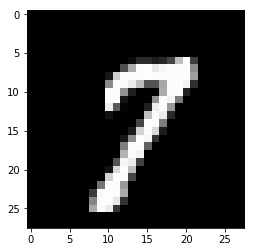

In [21]:
import matplotlib.pyplot as plt
plt.imshow(some_digit.reshape([28, 28]), cmap = 'gray')

## 3.3 validation check ##
### 3.3.1 cross validation check ###

In [22]:
## cross validation score
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, Y_train_5, cv=3, scoring='accuracy')

array([0.96730163, 0.96165   , 0.9679984 ])

In [28]:
## not5-classification function with sklearn.base
from sklearn.base import BaseEstimator
class not5classification(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [29]:
not5clf = not5classification()
cross_val_score(not5clf, X_train, Y_train_5, cv=3, scoring = 'accuracy')

array([0.90625, 0.909  , 0.90685])

### 3.3.2 confusion matrix ###

In [31]:
## confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

In [32]:
y_train_pred = cross_val_predict(sgd_clf, X_train, Y_train_5, cv=3)

In [33]:
confusion_matrix(Y_train_5, y_train_pred)

array([[54112,   330],
       [ 1731,  3827]], dtype=int64)

#### confusion matrix ####
[[ True nagative, False positive ] <br>
 [ False nagative, True positive ]] <br>

$$ precision = \frac{TP}{TP + FP}, \ recall = \frac{TP}{TP+FN} $$

In [39]:
## confusion matrix
# [TN, FP]
# [FN, TP]
# precision = TP / TP + FP
# recall = TP / TP + FN
from sklearn.metrics import precision_score, recall_score
print('precision :', precision_score(Y_train_5, y_train_pred))
print('recall :', recall_score(Y_train_5, y_train_pred))

precision : 0.9206158287226365
recall : 0.6885570349046419


### 3.3.3 f1 score, precision, recall ###

In [40]:
## f1 score(harmonic mean)
# 2 x precision * recall / (precision + recall) = TP / (TP + ( (FN+FP) / 2))
from sklearn.metrics import f1_score
print('F1 score :', f1_score(Y_train_5, y_train_pred))

F1 score : 0.7878538342768914


#### F-1 score(harmonic mean) ####
$$ F_1 = 2 \times \frac{precision \times recall}{precision + recall} = \frac{TP}{TP + \frac{FN+FP}{2}} $$

#### F-n score ####
$$ F_n = \frac {1}{ \frac{\alpha}{precision} + \frac{(1- \alpha)}{recall} } 
= ( \beta^2 + 1) \times \frac{precision \times recall}{( \beta^2 \times precision + recall )}, \beta^2 = \frac{( 1 -\alpha )}{\alpha} $$

### 3.3.4 precision/recall tradeoff ###

In [41]:
## decision fuction
y_score = sgd_clf.decision_function([some_digit])
print(y_score)

[-6.69009084]


In [43]:
threshold = -10
y_some_digit_pred = (y_score > threshold)
print(y_some_digit_pred)

[ True]


In [44]:
y_scores = cross_val_predict(sgd_clf, X_train, Y_train_5, cv=3, method='decision_function')

In [45]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(Y_train_5, y_scores)

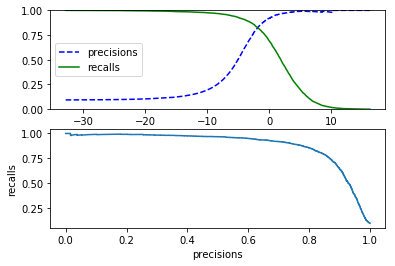

In [58]:
def _graph(precisions, recalls, thresholds):
    _, graph = plt.subplots(2)
    graph[0].plot(thresholds, precisions[:-1], 'b--', label = 'precisions')
    graph[0].plot(thresholds, recalls[:-1], 'g-', label = "recalls")
    graph[0].set_xlabel("thresholds")
    graph[0].legend(loc='center left')
    graph[0].set_ylim([0, 1])
    
    graph[1].plot(recalls, precisions)
    graph[1].set_xlabel('precisions')
    graph[1].set_ylabel('recalls')
    
_graph(precisions, recalls, thresholds)

### 3.3.5 ROC curve ###
#### Receiver Operating Characteristic (ROC) : 수신기 조작 특성 ####

In [59]:
## receiver operating characteristic
from sklearn.metrics import roc_curve

#### receiver operation characteristic ####
ROC =  true positive rate(TPR, = recall) for false positive rate(FPR, = specificty)

$$ FPR = \frac{FP}{FP + TN} = \frac{FP + TN - TN}{FP + TN} = 1 - \frac{TN}{FP + TN} = 1-TNR $$

In [60]:
fpr, tpr, threshold = roc_curve(Y_train_5, y_scores)

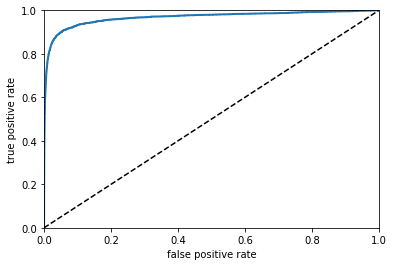

In [78]:
def plot_ROC_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
plot_ROC_curve(fpr, tpr, _)

In [73]:
## AUC(area under the curve)
from sklearn.metrics import roc_auc_score
print(' area under the curve :', roc_auc_score(Y_train_5, y_scores))

 area under the curve : 0.9672741113780625


In [74]:
## compare with RFC
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_forest = cross_val_predict(forest_clf, X_train, Y_train_5, cv=3, method='predict_proba')

In [75]:
y_scores_forest = y_forest[:, 1]
fpr_forest, tpr_forest, _ = roc_curve(Y_train_5, y_scores_forest)

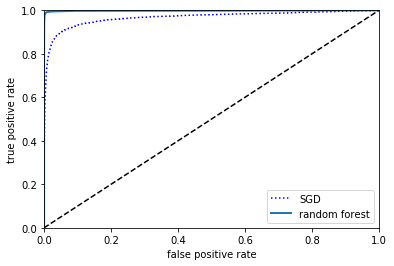

In [79]:
plt.plot(fpr, tpr, 'b:', label = "SGD")
plot_ROC_curve(fpr_forest, tpr_forest, 'random forest')
plt.legend(loc = 'lower right')

## 3.4 multicass classifier ##

In [85]:
sgd_clf.fit(X_train, mnist['train_label'])

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [82]:
sgd_clf.predict([X_train[5]])

array([4], dtype=uint8)

In [83]:
some_score = sgd_clf.decision_function([X_train[5]])
some_score

array([[-34.65265404, -10.69192006, -10.72953958,  -9.39205934,
          2.98166559,  -5.39139013, -12.8813999 ,  -7.67884074,
         -9.96062741,  -3.66864696]])

## 3.5 error checking ##

In [88]:
Y_train = mnist['train_label']
## standard scaler
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_train_std = std.fit_transform(X_train.astype(np.float32))
y_train_pred = cross_val_predict(sgd_clf, X_train_std, Y_train, cv=3)

In [90]:
conf_mx = confusion_matrix(Y_train, y_train_pred)
conf_mx

array([[5901,    3,   16,   10,   10,   38,   31,    4,   51,    0],
       [   0, 6302,   47,   29,    3,   28,   10,   10,  122,   13],
       [  36,   29, 5264,   85,   76,   16,  106,   48,  168,   10],
       [  46,   36,  122, 5296,    0,  204,   33,   54,  165,   81],
       [  21,   41,   22,   10, 5538,   15,   42,   11,   97,  171],
       [  58,   52,   38,  180,   70, 4797,  111,   24,  158,   70],
       [  28,   29,   55,    1,   31,   96, 5579,    0,   35,    0],
       [  27,   12,   54,   20,   48,   12,    2, 5858,   20,  205],
       [  28,  162,   58,  141,   17,  144,   47,   26, 5194,  128],
       [  40,   51,   19,   79,  154,   33,    2,  151,   83, 5302]],
      dtype=int64)

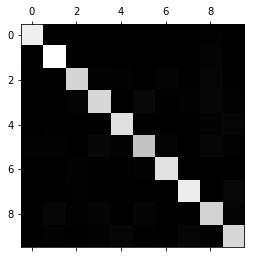

In [92]:
plt.matshow(conf_mx, cmap = 'gray')

In [93]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

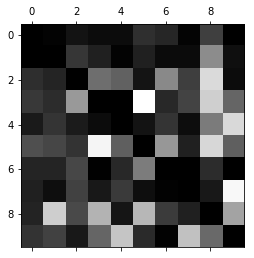

In [94]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = 'gray')